<a href="https://colab.research.google.com/github/gcosma/ACO-FS/blob/master/LabSolutions%5CLab_Exercise_(No_6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Lab Exercise (No. 6)**

**Task Overview**

Your task is to apply text summarisation and evaluation to the ArtReviews dataset. You will need to summarise using the different models and evaluate and compare the results. Briefly outline in bullets the main findings.

###***pre-work1: mount drive***

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


###***pre-work2: set datasets***

In [3]:
!pip install nltk bert-score datasets transformers sumy
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [2]:
!pip install --quiet datasets evaluate bert-score sumy rouge-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00


In [3]:
# import modules for this notebook
import nltk
from pprint import pprint
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
#from datasets import load_metric
from bert_score import score as bert_score
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
import numpy as np

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Use Arts dtasets with the LexRank model#

**LexRank (extractive)** steps involved in LexRank summarization typically include:

Preprocessing: Tokenization, stopping, and stemming (or lemmatization) of the document text.
Sentence Similarity: Computing the similarity between all pairs of sentences, usually with cosine similarity of their TF-IDF representations.
Graph Construction: Building a graph where sentences are nodes connected by edges weighted by their similarity. A threshold is often applied to similarity scores to decide whether an edge should exist between two sentences.
Centrality Calculation: Applying the PageRank algorithm or a similar technique to rank sentences based on their centrality in the graph.
Summary Extraction: Selecting the highest-ranked sentences (up to a desired summary length or until a cumulative relevance threshold is reached) to form the summary.

#### Load datasets ####

In [4]:
data_path = "/content/drive/My Drive/Colab Notebooks/21COP509/LabDatasets/"
!ls "/content/drive/My Drive/Colab Notebooks/21COP509/LabDatasets/"

# select datasets
datasets = 'Arts5000' # ArtsAll, Arts5000

if datasets == 'ArtsAll':
  # Arts all
  data_all_reviews = 'ArtsReviews.txt'
  data_all_ratings = 'ArtsRatings.txt'
  data_train_reviews = 'ArtsReviews_train.txt'
  data_test_reviews = 'ArtsReviews_test.txt'
  data_train_ratings = 'ArtsRatings_train.txt'
  data_test_ratings = 'ArtsRatings_test.txt'
else:
  # Arts 5000
  data_all_reviews = 'Reduced_ArtsReviews_5000.txt'
  data_all_ratings = 'Reduced_ArtsRatings_5000.txt'
  data_train_reviews = 'ArtsReviews_5000_train.txt'
  data_test_reviews = 'ArtsReviews_5000_test.txt'
  data_train_ratings = 'ArtsRatings_5000_train.txt'
  data_test_ratings = 'ArtsRatings_5000_test.txt'

ArtsRatings_5000_test.txt   ArtsReviews_5000_train.txt	Reduced_ArtsRatings_5000.txt
ArtsRatings_5000_train.txt  glove.6B.100d.txt		Reduced_ArtsReviews_5000.txt
ArtsReviews_5000_test.txt   metamorphosis_clean.txt	review_polarity


## Load specific number of lines from a file

In [5]:
# Function to load a specific number of lines from a file
def load_doc_lines(NumLines, filename):
    # Open the file in read-text ('rt') mode
    file = open(filename, 'rt')
    lines = list()  # Initialize an empty list to hold the lines
    counter = 0  # Initialize a counter to keep track of the number of lines read

    # Loop to read lines until the desired number of lines (NumLines) is reached
    while True:
        if counter == NumLines:
            break  # Exit the loop if the target number of lines has been read
        counter += 1
        line = file.readline()  # Read the next line from the file
        if not line:
            break  # If no line is read (end of file), exit the loop
        lines.append(line.strip("\n"))  # Add the line to the list, removing the newline character

    file.close()  # Close the file after reading the lines
    return lines  # Return the list of lines

# Specify the number of lines to read from the file
NumLines = 10
# Load the specified number of lines from the file into 'corpus'
corpus = load_doc_lines(NumLines, data_path + data_all_reviews)

# Print the number of lines read and the content of 'corpus'
print(len(corpus))
print(corpus)


10
['I found the product to be overpriced. This is a good idea, but not worth the money. The box was a different color than pictured, yellow. The stencils are thin and flimsy. Quite a few more stencils should be included for the price or the price should be significantly lower.', 'These pliers are not stainless steel. They came packed/coated with a yellowish oil, like mild steel tools often are. The description didn\'t specify the materials so now I know to look for that. The manufacturers box that they were delivered in had the word "Stainless" before Steel scratched off with a black magic marker.', 'GREAT buy! So glad I got this. I now have two of these -- one to keep at home and one to take on vacation.', "Still having problems getting the upper tension correct. Still too tight. Keep re-threading the machine but haven't found the problem yet.", 'The Velcro bottom would not stick to the place I wanted it to. So when I pulled it off, usually took it all off. I think I got the one sitt

# Lexrank summarisation

In [11]:
!pip install sumy nltk

In [16]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.nlp.stemmers import Stemmer
from typing import List, Union
import nltk
import os

def ensure_nltk_resources():
    """
    Download all required NLTK resources including punkt_tab.
    """
    try:
        # Download punkt data for tokenization
        nltk.download('punkt_tab')
        nltk.download('punkt')

        # Download other necessary resources
        resources = [
            'averaged_perceptron_tagger',
            'maxent_ne_chunker',
            'words',
            'stopwords'
        ]

        for resource in resources:
            nltk.download(resource, quiet=True)

        # Verify punkt tokenizer is available
        nltk.data.find('tokenizers/punkt/english.pickle')

    except LookupError as e:
        print(f"Error downloading NLTK resources: {str(e)}")
        # Fallback to basic sentence tokenization if NLTK resources fail
        return False
    except Exception as e:
        print(f"Unexpected error during NLTK setup: {str(e)}")
        return False

    return True

class SimpleSentenceTokenizer:
    """Fallback tokenizer when NLTK resources are unavailable"""
    def __init__(self):
        self.sentence_endings = {'.', '!', '?'}

    def tokenize(self, text):
        sentences = []
        current = []

        for char in text:
            current.append(char)
            if char in self.sentence_endings:
                sentences.append(''.join(current).strip())
                current = []

        if current:  # Add any remaining text
            sentences.append(''.join(current).strip())

        return sentences

def generate_summary(corpus: Union[str, List[str]],
                    num_sentences: int = 5,
                    language: str = "english") -> List[str]:
    """
    Generate a summary from a text corpus using LexRank algorithm.
    Falls back to simple tokenization if NLTK resources are unavailable.

    Args:
        corpus: Input text(s) - can be a single string or list of strings
        num_sentences: Number of sentences in the summary (default: 5)
        language: Language of the text for tokenization (default: "english")

    Returns:
        List of summary sentences as strings
    """
    # Input validation
    if not corpus:
        raise ValueError("Corpus cannot be empty")
    if num_sentences < 1:
        raise ValueError("Number of sentences must be positive")

    # Convert corpus to string if it's a list
    if isinstance(corpus, list):
        corpus_str = " ".join(str(item) for item in corpus if item)
    else:
        corpus_str = str(corpus)

    # Ensure the corpus isn't just whitespace
    if not corpus_str.strip():
        raise ValueError("Corpus contains no text content")

    try:
        # Try to ensure NLTK resources are available
        nltk_available = ensure_nltk_resources()

        if nltk_available:
            # Use NLTK-based tokenizer
            parser = PlaintextParser.from_string(corpus_str, Tokenizer(language))
        else:
            # Fallback to simple tokenizer
            simple_tokenizer = SimpleSentenceTokenizer()
            sentences = simple_tokenizer.tokenize(corpus_str)
            class SimpleDocument:
                def __init__(self, sents):
                    self.sentences = sents
            parser = SimpleDocument(sentences)

        summarizer = LexRankSummarizer()

        # Try to get stopwords if available
        try:
            summarizer.stop_words = set(nltk.corpus.stopwords.words(language))
        except:
            summarizer.stop_words = set()

        # Generate summary
        if hasattr(parser, 'document'):
            document_length = len(parser.document.sentences)
            summary = summarizer(parser.document, min(num_sentences, document_length))
        else:
            document_length = len(parser.sentences)
            sentences_to_use = min(num_sentences, document_length)
            summary = parser.sentences[:sentences_to_use]

        return [str(sentence).strip() for sentence in summary]

    except Exception as e:
        raise Exception(f"Error during summarization: {str(e)}")

def print_summary(corpus: Union[str, List[str]],
                 num_sentences: int = 5,
                 language: str = "english") -> None:
    """
    Generate and print a summary with proper formatting and error handling.
    """
    try:
        summary_sentences = generate_summary(corpus, num_sentences, language)

        if not summary_sentences:
            print("No summary could be generated from the provided text.")
            return

        print("\nDocument Summary:")
        print("-" * 50)
        for i, sentence in enumerate(summary_sentences, 1):
            print(f"\nSentence {i}:")
            print(sentence)
        print("-" * 50)

    except Exception as e:
        print(f"Error: {str(e)}")

# Example usage
if __name__ == "__main__":
    # Example corpus
    sample_corpus = [
        "Machine learning is a field of artificial intelligence.",
        "It focuses on developing computer systems that can learn from data.",
        "Deep learning is a subset of machine learning.",
        "Neural networks are key components in deep learning systems.",
        "Training data is essential for machine learning models."
    ]

    # Generate and print summary
    print_summary(sample_corpus, num_sentences=3)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Document Summary:
--------------------------------------------------

Sentence 1:
Machine learning is a field of artificial intelligence.

Sentence 2:
It focuses on developing computer systems that can learn from data.

Sentence 3:
Deep learning is a subset of machine learning.
--------------------------------------------------


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Evaluate using reference summaries

In [20]:
from typing import List, Dict, Union, Optional
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import evaluate
from bert_score import score as bert_score
import numpy as np
from dataclasses import dataclass

@dataclass
class EvaluationResults:
    """Container for all evaluation metric results."""
    bleu_scores: List[float]
    meteor_scores: List[float]
    rouge_scores: Dict
    bert_scores: Dict[str, float]

    def __str__(self) -> str:
        """Pretty print the evaluation results."""
        return (
            f"BLEU Scores: {np.mean(self.bleu_scores):.4f}\n"
            f"METEOR Scores: {np.mean(self.meteor_scores):.4f}\n"
            f"ROUGE Scores: {self.rouge_scores}\n"
            f"BERTScore: {self.bert_scores}"
        )

class TextEvaluator:
    """Class for evaluating text summaries using multiple metrics."""

    def __init__(self):
        self.chencherry = SmoothingFunction()
        self.rouge = evaluate.load('rouge')

    def preprocess_texts(self, texts: Union[List[str], List[object]]) -> List[str]:
        """Convert input texts to strings if they're objects."""
        return [str(text) for text in texts]

    def calculate_bleu(self, reference: str, candidate: str) -> float:
        """Calculate BLEU score for a single pair of texts."""
        try:
            return sentence_bleu(
                [reference.split()],
                candidate.split(),
                smoothing_function=self.chencherry.method1
            )
        except Exception as e:
            print(f"Error calculating BLEU score: {e}")
            return 0.0

    def calculate_meteor(self, reference: str, candidate: str) -> float:
        """Calculate METEOR score for a single pair of texts."""
        try:
            tokenized_reference = word_tokenize(reference)
            tokenized_candidate = word_tokenize(candidate)
            return meteor_score([tokenized_reference], tokenized_candidate)
        except Exception as e:
            print(f"Error calculating METEOR score: {e}")
            return 0.0

    def calculate_rouge(self, references: List[str], candidates: List[str]) -> Dict:
        """Calculate ROUGE scores for a list of text pairs."""
        try:
            return self.rouge.compute(
                predictions=candidates,
                references=references
            )
        except Exception as e:
            print(f"Error calculating ROUGE scores: {e}")
            return {}

    def calculate_bert_score(self, references: List[str], candidates: List[str]) -> Dict[str, float]:
        """Calculate BERTScore for a list of text pairs."""
        try:
            P, R, F1 = bert_score(
                candidates,
                references,
                lang="en",
                rescale_with_baseline=True
            )
            return {
                "Precision": P.mean().item(),
                "Recall": R.mean().item(),
                "F1": F1.mean().item()
            }
        except Exception as e:
            print(f"Error calculating BERTScore: {e}")
            return {"Precision": 0.0, "Recall": 0.0, "F1": 0.0}

    def evaluate(self,
                summaries: Union[List[str], List[object]],
                references: List[str],
                max_samples: Optional[int] = None) -> EvaluationResults:
        """
        Evaluate summaries using multiple metrics.

        Args:
            summaries: List of generated summaries (strings or objects)
            references: List of reference summaries
            max_samples: Optional limit on number of samples to evaluate

        Returns:
            EvaluationResults object containing all metric scores
        """
        # Preprocess inputs
        summary_texts = self.preprocess_texts(summaries)
        if max_samples:
            summary_texts = summary_texts[:max_samples]
            references = references[:max_samples]

        # Ensure equal number of summaries and references
        min_len = min(len(summary_texts), len(references))
        summary_texts = summary_texts[:min_len]
        references = references[:min_len]

        # Calculate individual metrics
        bleu_scores = [
            self.calculate_bleu(ref, sum_text)
            for ref, sum_text in zip(references, summary_texts)
        ]

        meteor_scores = [
            self.calculate_meteor(ref, sum_text)
            for ref, sum_text in zip(references, summary_texts)
        ]

        rouge_scores = self.calculate_rouge(references, summary_texts)
        bert_scores = self.calculate_bert_score(references, summary_texts)

        return EvaluationResults(
            bleu_scores=bleu_scores,
            meteor_scores=meteor_scores,
            rouge_scores=rouge_scores,
            bert_scores=bert_scores
        )

# Example usage
if __name__ == "__main__":
    # Example summaries and references
    summaries = [
        "the product is expensive and should cost less",
        "tools came with yellow oil coating not mentioned in description",
        "excellent purchase now own two",
        "still having issues with upper tension",
        "velcro bottom would not adhere to surface"
    ]

    references = [
        "the product is overpriced the price should be significantly lower",
        "They came packed/coated with a yellowish oil, like mild steel tools often are. The description didn't specify the materials",
        "GREAT buy! I now have two of these",
        "Still having problems getting the upper tension correct.",
        "The Velcro bottom would not stick to the place I wanted it to."
    ]

    # Create evaluator and run evaluation
    evaluator = TextEvaluator()
    results = evaluator.evaluate(summaries, references)
    print(results)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BLEU Scores: 0.0611
METEOR Scores: 0.3595
ROUGE Scores: {'rouge1': 0.42625152625152635, 'rouge2': 0.1833333333333333, 'rougeL': 0.41514041514041516, 'rougeLsum': 0.4175115207373272}
BERTScore: {'Precision': 0.6047293543815613, 'Recall': 0.4709230959415436, 'F1': 0.5375301241874695}


#Redo but show plots


Detailed Evaluation Results:
--------------------------------------------------------------------------------

Summary 1:
Summary:   the product is expensive and should cost less
Reference: the product is overpriced the price should be significantly lower
BLEU:      0.1150
METEOR:    0.4551

Summary 2:
Summary:   tools came with yellow oil coating not mentioned in description
Reference: They came packed/coated with a yellowish oil, like mild steel tools often are. The description didn't specify the materials
BLEU:      0.0121
METEOR:    0.2050

Summary 3:
Summary:   excellent purchase now own two
Reference: GREAT buy! I now have two of these
BLEU:      0.0351
METEOR:    0.3424

Summary 4:
Summary:   still having issues with upper tension
Reference: Still having problems getting the upper tension correct.
BLEU:      0.0685
METEOR:    0.4310

Summary 5:
Summary:   velcro bottom would not adhere to surface
Reference: The Velcro bottom would not stick to the place I wanted it to.
BLEU:   

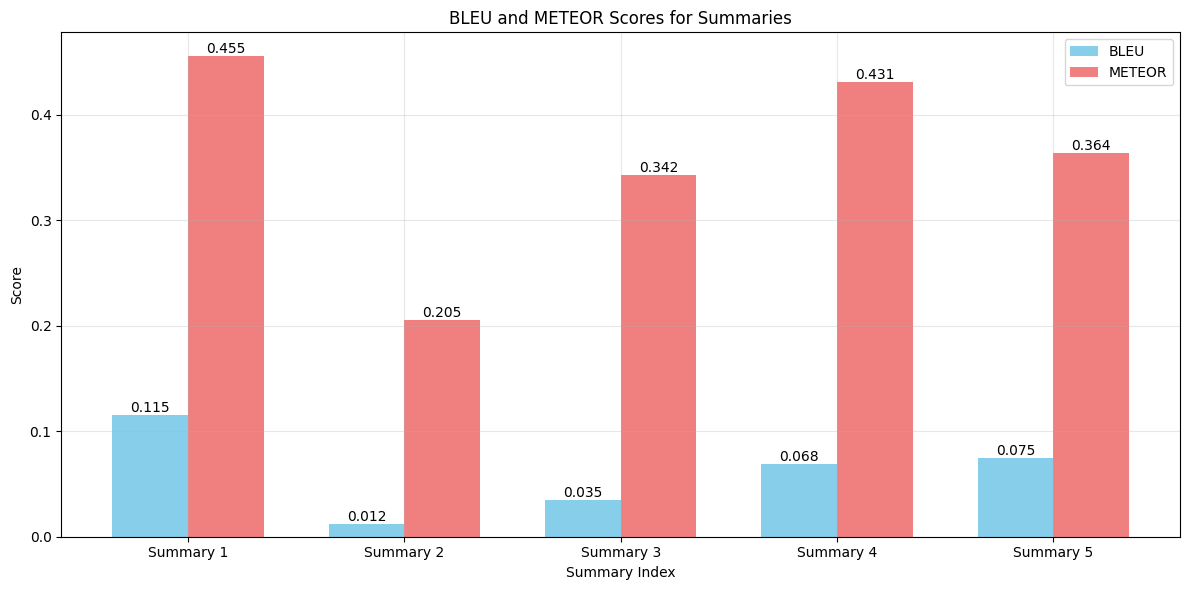

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from typing import List

class TextEvaluator:
    def __init__(self):
        self.chencherry = SmoothingFunction()
        self.summaries = [
            "the product is expensive and should cost less",
            "tools came with yellow oil coating not mentioned in description",
            "excellent purchase now own two",
            "still having issues with upper tension",
            "velcro bottom would not adhere to surface"
        ]
        self.references = [
            "the product is overpriced the price should be significantly lower",
            "They came packed/coated with a yellowish oil, like mild steel tools often are. The description didn't specify the materials",
            "GREAT buy! I now have two of these",
            "Still having problems getting the upper tension correct.",
            "The Velcro bottom would not stick to the place I wanted it to."
        ]

    def calculate_bleu_scores(self) -> List[float]:
        """Calculate BLEU scores for each summary-reference pair."""
        bleu_scores = []
        for summary, reference in zip(self.summaries, self.references):
            score = sentence_bleu(
                [reference.split()],
                summary.split(),
                smoothing_function=self.chencherry.method1
            )
            bleu_scores.append(score)
        return bleu_scores

    def calculate_meteor_scores(self) -> List[float]:
        """Calculate METEOR scores for each summary-reference pair."""
        meteor_scores = []
        for summary, reference in zip(self.summaries, self.references):
            ref_tokens = word_tokenize(reference.lower())
            sum_tokens = word_tokenize(summary.lower())
            score = meteor_score([ref_tokens], sum_tokens)
            meteor_scores.append(score)
        return meteor_scores

    def plot_scores(self, bleu_scores: List[float], meteor_scores: List[float]):
        """Create visualization of evaluation metrics."""
        plt.figure(figsize=(12, 6))

        indices = np.arange(len(self.summaries))
        width = 0.35

        plt.bar(indices - width/2, bleu_scores, width, label='BLEU', color='skyblue')
        plt.bar(indices + width/2, meteor_scores, width, label='METEOR', color='lightcoral')

        plt.xlabel('Summary Index')
        plt.ylabel('Score')
        plt.title('BLEU and METEOR Scores for Summaries')
        plt.xticks(indices, [f'Summary {i+1}' for i in range(len(self.summaries))])
        plt.legend()
        plt.grid(True, alpha=0.3)

        for i, score in enumerate(bleu_scores):
            plt.text(i - width/2, score, f'{score:.3f}', ha='center', va='bottom')
        for i, score in enumerate(meteor_scores):
            plt.text(i + width/2, score, f'{score:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def print_detailed_results(self, bleu_scores: List[float], meteor_scores: List[float]):
        """Print detailed evaluation results."""
        print("\nDetailed Evaluation Results:")
        print("-" * 80)

        for i, (summary, reference, bleu, meteor) in enumerate(
            zip(self.summaries, self.references, bleu_scores, meteor_scores), 1):
            print(f"\nSummary {i}:")
            print(f"Summary:   {summary}")
            print(f"Reference: {reference}")
            print(f"BLEU:      {bleu:.4f}")
            print(f"METEOR:    {meteor:.4f}")

        print("\nAggregate Scores:")
        print(f"Average BLEU:   {np.mean(bleu_scores):.4f}")
        print(f"Average METEOR: {np.mean(meteor_scores):.4f}")

def main():
    evaluator = TextEvaluator()
    bleu_scores = evaluator.calculate_bleu_scores()
    meteor_scores = evaluator.calculate_meteor_scores()
    evaluator.print_detailed_results(bleu_scores, meteor_scores)
    evaluator.plot_scores(bleu_scores, meteor_scores)

if __name__ == "__main__":
    main()

##Can you repeat these with an abstractive summarisation model?